# Clasificación de rótulos de tránsito (EEUU) utilizando la arquitectura de CNN Le_Net  

# Enunciado del problema

A lo largo del tiempo, se han desarrollado muchas arquitecturas de redes neuronales, algunas de ellas se han vuelto clásicas.  Una de ellas es una CNN (red neuronal convolucional) desarrollada por Yann LeCun a la que le denominó Le-Net.  Pueden ver el artículo original en:

http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf

El diseño es el siguiente:

![Arquitectura Le-Net](../Images/Le-Net.png)

* C: Capa de Convolución, 
* S: Capa de Submuestreo (Pooling), 
* F: Capa completamente conectada (Fully Connected)

En este caso de estudio, se proveen imágenes de rótulos de tráfico y el objetivo es entrenar una red Le-Net para que las pueda clasificar

- El conjunto de datos contiene 43 clases diferentes de imágenes. 
- Las clases se listan abajo: 

    0 - Limite velocidad (20km/h)  
    1 - Limite velocidad (30km/h)  
    2 - Limite velocidad (50km/h)  
    3 - Limite velocidad (60km/h)  
    4 - Limite velocidad (70km/h)  
    5 - Limite velocidad (80km/h)  
    6 - Fin de limite velocidad (80km/h)'  
    7 - Limite velocidad (100km/h)  
    8 - Limite velocidad (120km/h)  
    9 - No rebasar  
    10 - No rebasar para vehiculos mayores de 3.5 tonladas metricas  
    11 - Derecho-de-via en la siguiente interseccion  
    12 - Camino prioritario  
    13 - Ceda el paso  
    14 - Alto  
    15 - No vehiculos  
    16 - Prohibido vehiculos mayores de 3.5 toneladas metricas  
    17 - No hay entrada
    18 - Precaucion general  
    19 - Curva peligrosa a la izquierda  
    20 - Curva peligrosa a la derecha  
    21 - Doble curva  
    22 - Camino disparejo  
    23 - Camino resbaloso  
    24 - Camino se reduce a la derecha  
    25 - Trabajos adelante  
    26 - Señales de Trafico -semaforos-  
    27 - Cruce de peatones  
    28 - Cruce de Niños  
    29 - Cruce de bicicletas  
    30 - Cuidado hielo/nieve  
    31 - Cruce de animales silvestres  
    32 - Fin de todos los limites de velocidad y rebase  
    33 - Gire a la derecha adelante  
    34 - Gire a la izquierda adelante  
    35 - Recto solo  
    36 - Vaya recto o a la rerecha  
    37 - Vaya recto o a la izquierda  
    38 - Mantengase a la derecha  
    39 - Mantengase a la izquierda  
    40 - Vuelta en U obligada  
    41 - Fin de no rebasar  
    42 - Fin de no rebasar para vehiculos mayores de 3.5 toneladas metricas




Referencias (Señales de Tráfico)

J. Stallkamp, M. Schlipsing, J. Salmen, and C. Igel. The German Traffic Sign Recognition Benchmark: A multi-class classification competition. In Proceedings of the IEEE International Joint Conference on Neural Networks, pages 1453–1460. 2011. 

@inproceedings{Stallkamp-IJCNN-2011,
    author = {Johannes Stallkamp and Marc Schlipsing and Jan Salmen and Christian Igel},
    booktitle = {IEEE International Joint Conference on Neural Networks},
    title = {The {G}erman {T}raffic {S}ign {R}ecognition {B}enchmark: A multi-class classification competition},
    year = {2011},
    pages = {1453--1460}
}



# IMPORTAR LIBRERIAS

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [32]:
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Obtener Datos

El módulo de Pickle implementa protocolos binarios para la serialización y de-serialización de objetos Python

In [4]:
with open("entrenamiento.p", mode='rb') as datos_entreno:
    entreno = pickle.load(datos_entreno)
with open("validacion.p", mode='rb') as datos_validacion:
    valida = pickle.load(datos_validacion)
with open("prueba.p", mode='rb') as datos_prueba:
    prueba = pickle.load(datos_prueba)

In [5]:
X_entreno, y_entreno = entreno['features'], entreno['labels']
X_valida, y_valida = valida['features'], valida['labels']
X_prueba, y_prueba = prueba['features'], prueba['labels']


# EXPLORACION DE LAS IMAGENES

Mostrar que las imágenes no están "barajeadas"

In [6]:
# Numero de ejemplos de entreno
n_entreno = X_entreno.shape[0]

# Numero de ejemplos de validacion
n_validacion = X_valida.shape[0]

# Numero de ejemplos de prueba
n_prueba = X_prueba.shape[0]

# TODO: tamaño de las imagenes de señales de trancito  
image_shape = X_entreno.shape[1:4]

# Numero de clases
n_classes = np.unique(ar=y_entreno).shape[0]

image_depth_dimension = X_entreno.shape[3]

print("Number of training examples =", n_entreno)
print("Number of testing examples =", n_prueba)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


# PREPARACION DE LOS DATOS

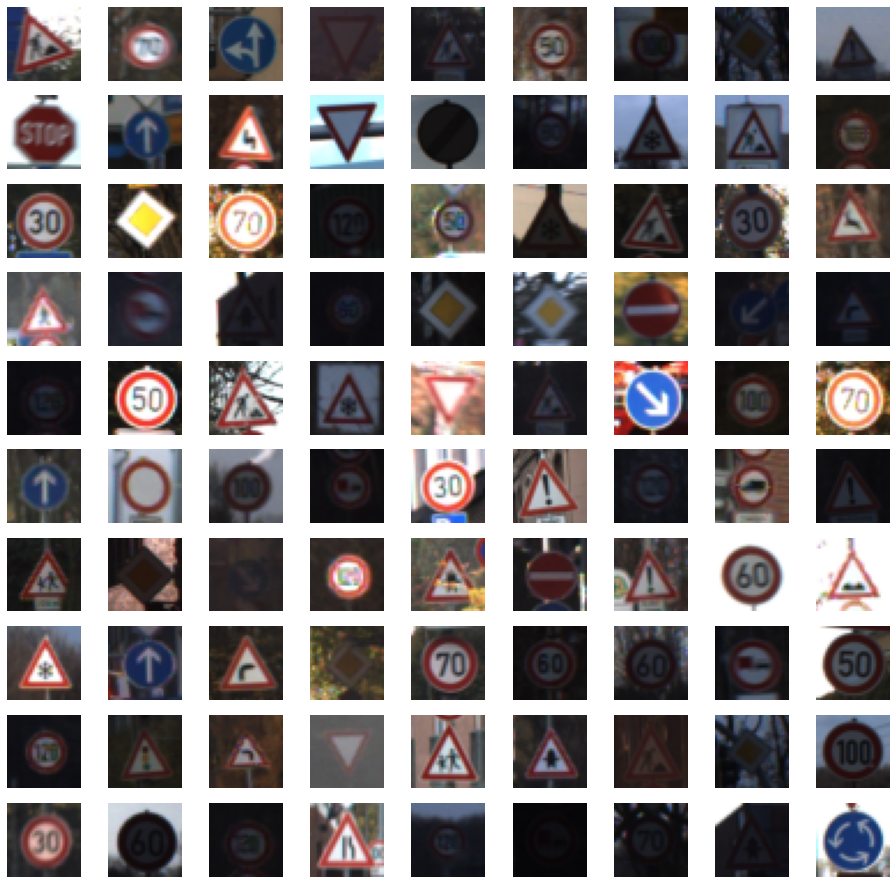

In [7]:
# "Barajear" los datos
#funcion qeu agrra las imagenes de los dataset y los muestra
def plot_digits(X, Y):
    %matplotlib inline
    fig=plt.figure(figsize=(16, 16))
    columns = 9
    rows = 10
    for i in range(1, columns*rows +1):
        # show random images from the dataset
        img = X[randint(0, Y-1)]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.axis('off')   
    plt.show()

plot_digits(X_entreno, n_entreno)


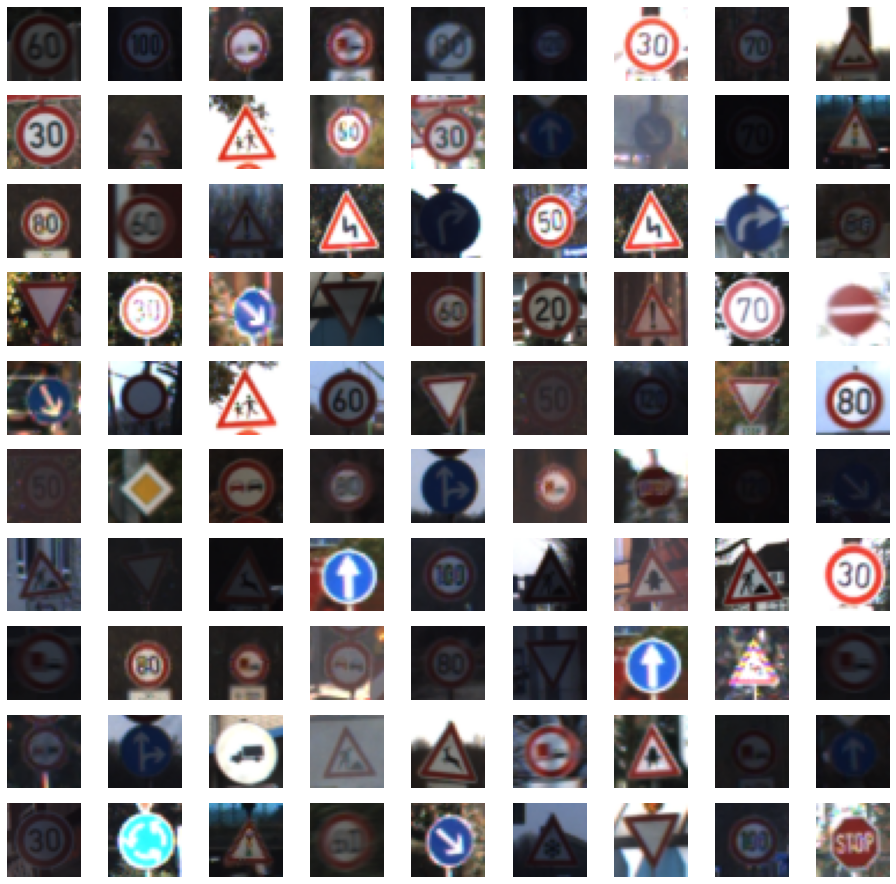

In [8]:
plot_digits(X_valida, n_validacion)

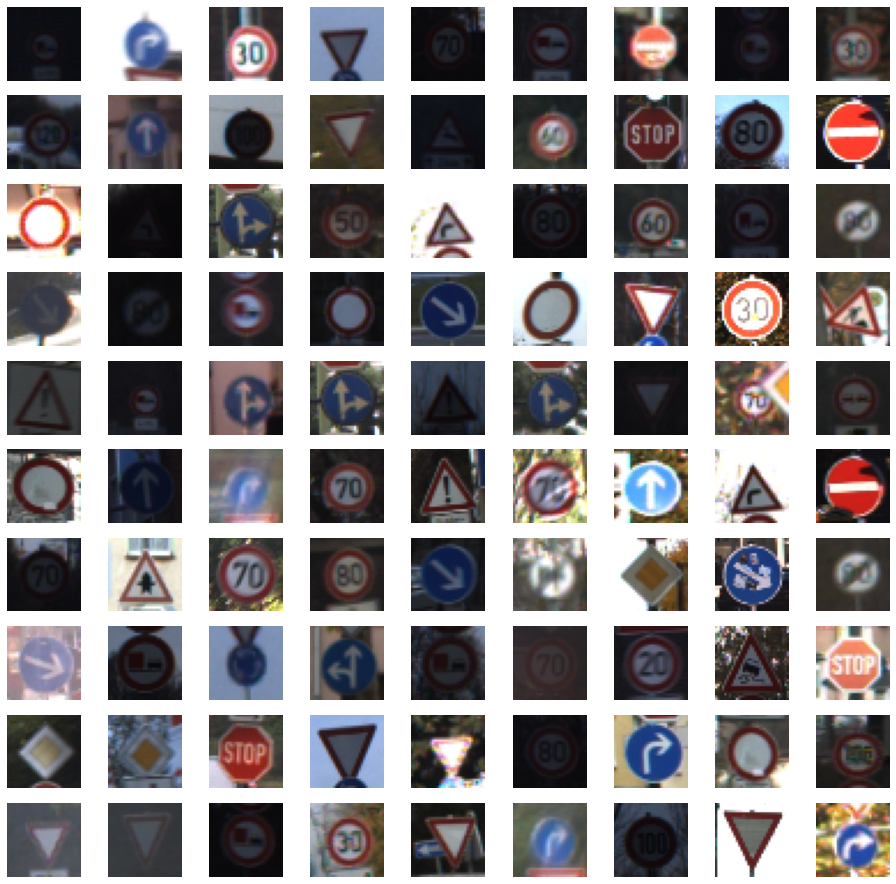

In [9]:
plot_digits(X_prueba, n_prueba)

In [10]:
# Normalizar los datos
def normalize(x):
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

In [11]:
normalized_train = np.zeros([n_entreno,32,32,3])
normalized_validation = np.zeros([n_validacion,32,32,3])
normalized_test = np.zeros([n_prueba,32,32,3])
for i in range(0,n_entreno):
    normalized_train[i] = normalize(X_entreno[i])
for i in range(0,n_validacion):
    normalized_validation[i] = normalize(X_valida[i])
for i in range(0,n_prueba):
    normalized_test[i] = normalize(X_prueba[i])

assert(X_entreno.shape==normalized_train.shape)

In [12]:
n_entreno_y = y_entreno.shape[0]
n_validacion_y = y_valida.shape[0]
n_prueba_y = y_prueba.shape[0]

In [13]:
# normalized_train_y = np.zeros([n_entreno,32,32,3])
# normalized_validation_y = np.zeros([n_validacion,32,32,3])
# normalized_test_y = np.zeros([n_prueba,32,32,3])
# for i in range(0,n_entreno_y):
#     normalized_train_y[i] = normalize(y_entreno[i])
# for i in range(0,n_validacion_y):
#     normalized_validation_y[i] = normalize(y_valida[i])
# for i in range(0,n_prueba_y):
#     normalized_test_y[i] = normalize(y_prueba[i])

# assert(y_entreno.shape==normalized_train_y.shape)

Text(0.5, 1.0, 'Imagen Normalizada')

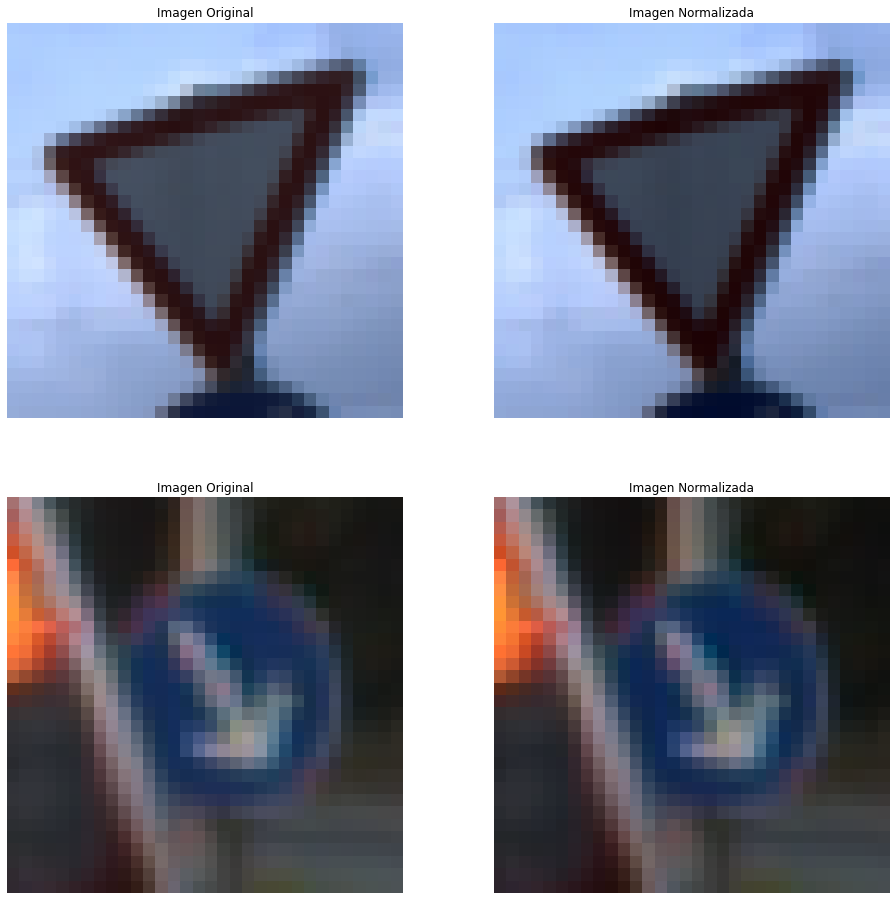

In [14]:
f, axarr = plt.subplots(nrows=2,ncols=2,figsize = (16,16))
randomindex = randint(0,n_entreno-1)
axarr[0,0].imshow(X_entreno[randomindex])
axarr[0,0].axis('off')
axarr[0,0].set_title('Imagen Original')
axarr[0,1].imshow(normalized_train[randomindex])
axarr[0,1].axis('off')
axarr[0,1].set_title('Imagen Normalizada')
randomindex = randint(0,n_entreno-1)
axarr[1,0].imshow(X_entreno[randomindex])
axarr[1,0].axis('off')
axarr[1,0].set_title('Imagen Original')
axarr[1,1].imshow(normalized_train[randomindex])
axarr[1,1].axis('off')
axarr[1,1].set_title('Imagen Normalizada')

In [15]:
# Convertir imágenes a blanco y negro


# Entrenamiento del modelo

In [16]:
X_entreno = normalized_train

X_validacion = normalized_validation

X_prueba = normalized_test

El modelo consiste de las siguientes capas: 

- Paso 1: La primera capa convolucional #1

    - Entrada = 32x32x1
    - Salida = 28x28x6
    - Salida = (Entrada-filtro+1)/Paso* => (32-5+1)/1=28
    - Se utiliza un filtro de 5x5 con una profundidad de entrada 3 y profundidad de salida 6
    - Aplicar una función de activación RELU a la salida
    - Submuestreo (pooling) para la entrada, Entrada = 28x28x6 y Salida = 14x14x6


    * Paso (Stride) es la cantidad por la cual el kernel se desplaza cuando el kernel se pasa sobre la imagen.

- Paso 2: La segunda capa covolucional #2

    - Entrada = 14x14x6
    - Salida = 10x10x16
    - Capa 2: Capa convolutional con salida = 10x10x16
    - Output = (Input-filter+1)/strides => 10 = 14-5+1/1
    - Aplicar una función de activación RELU a la salida
    - Submuestreo (pooling) con Entrada = 10x10x16 Salida = 5x5x16

- Paso 3: "Aplanar" la red (convertir a una dimensión)

    - Entrada = 5x5x16 y Salida = 400

- Paso 4: Capa plenamenente conectada

    - Capa 3: Capa plenamente conectada con Entrada = 400 y Salida = 120
    - Aplicar una función de activación RELU a la salida

- Paso 5: Otra capa plenamente conectada

    - Capa 4: Capa plenamente conectada con Entrada = 120 y Salida = 84
    - Aplicar una función de activación RELU a la salida

- Paso 6: Otra capa plenamente conectada

    - Capa 5: Capa plenamente conectada con Entrada = 84 y Salida = 43

# Importar librerías para construir el modelo

In [17]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Rescaling, AveragePooling2D, Dropout

In [18]:
# Crear el modelo
model = Sequential([
    Rescaling(1, input_shape=(32, 32, 3)),
    Conv2D(filters=6, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=400, kernel_size=(5, 5), activation='relu'),
    Dropout(0.2), 
    Flatten(),
    Dense(units=120, activation='relu'),
    Dense(units=43, activation='softmax')
])

2022-11-13 22:40:56.644115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 400)         1

In [20]:
from keras.utils import to_categorical
y_t1 = to_categorical(y_entreno, 43)
y_t2 = to_categorical(y_valida, 43)

In [21]:
# Entrenar el modelo y guardar los datos en un hhistorial

eps = 15

# anc = model.fit(X_entreno, y_entreno, batch_size=32, epochs=eps, validation_data=(X_validacion, y_valida))
anc = model.fit(X_entreno, y_t1, batch_size=32, epochs=eps, validation_data=(X_validacion, y_t2))

Epoch 1/15
1088/1088 [==============================] - 17s 14ms/step - loss: 1.0721 - accuracy: 0.6927 - val_loss: 0.4726 - val_accuracy: 0.8540
Epoch 2/15
1088/1088 [==============================] - 17s 15ms/step - loss: 0.2755 - accuracy: 0.9161 - val_loss: 0.4103 - val_accuracy: 0.8760
Epoch 3/15
1088/1088 [==============================] - 18s 17ms/step - loss: 0.1556 - accuracy: 0.9538 - val_loss: 0.2945 - val_accuracy: 0.9154
Epoch 4/15
1088/1088 [==============================] - 17s 16ms/step - loss: 0.1084 - accuracy: 0.9678 - val_loss: 0.2751 - val_accuracy: 0.9234
Epoch 5/15
1088/1088 [==============================] - 20s 18ms/step - loss: 0.0794 - accuracy: 0.9760 - val_loss: 0.3073 - val_accuracy: 0.9240
Epoch 6/15
1088/1088 [==============================] - 19s 18ms/step - loss: 0.0645 - accuracy: 0.9805 - val_loss: 0.2443 - val_accuracy: 0.9392
Epoch 7/15
1088/1088 [==============================] - 18s 16ms/step - loss: 0.0489 - accuracy: 0.9852 - val_loss: 0.3503 -

# EVALUACION DEL MODELO

In [22]:
# Evaluar el modelo e indicar la exactitud con los datos de prueba
from sklearn.metrics import accuracy_score

pred = model.predict(X_prueba)
# accuracy_score(y_prueba, pred)
pred

395/395 [==============================] - 2s 4ms/step


array([[0.00000000e+00, 2.26997997e-37, 0.00000000e+00, ...,
        1.54501471e-27, 3.38051589e-24, 9.37544068e-24],
       [6.52191426e-11, 1.00000000e+00, 9.04558095e-11, ...,
        1.04250203e-27, 5.89372745e-28, 1.20649042e-26],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.82124844e-29, 1.20579536e-34, 0.00000000e+00],
       ...,
       [1.28680712e-11, 5.47659071e-03, 8.70448366e-06, ...,
        3.42694817e-10, 9.96023373e-05, 1.64583113e-07],
       [1.21402285e-14, 1.28130440e-08, 5.17616262e-11, ...,
        5.77524964e-12, 8.37934159e-17, 1.82944545e-12],
       [3.48636249e-31, 1.87333284e-24, 2.48195103e-10, ...,
        9.52316178e-15, 2.26117118e-24, 1.46041012e-19]], dtype=float32)

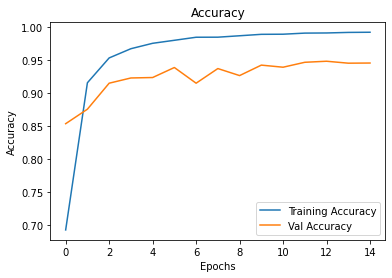

In [23]:
# Generar gráfica de Exactitud y de Entrenamiento y Validación
plt.figure(0)
plt.plot(anc.history['accuracy'], label='Training Accuracy')
plt.plot(anc.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

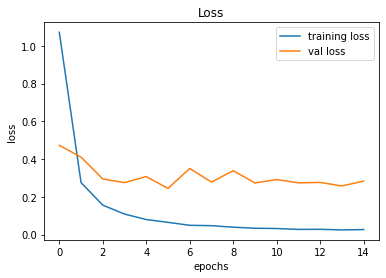

In [24]:
# Generar gráfica de Pérdida de Entrenamiento y Validación
plt.figure(1)
plt.plot(anc.history['loss'], label='training loss')
plt.plot(anc.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# Obtener las predicciones para los datos de prueba

In [29]:
#  A partir de la versión 2.6 de tensorflow, la siguiente instrucción
#    puede dar el error:  ‘Sequential’ object has no attribute ‘predict_classes’
#    por lo que se sustituye por la que le sigue
#
#clases_predichas = modelo_cnn.predict_classes(X_prueba_gris_norm)

clases_predichas = np.argmax(model.predict(X_prueba),axis=1)

# se obtienen los índices para poder graficar
index = np.random.choice(X_prueba.shape[0], size=(7*7), replace=False)  



395/395 [==============================] - 3s 6ms/step


<AxesSubplot:>

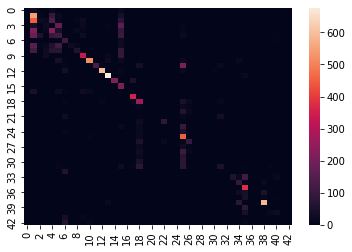

In [39]:
# Generar un mapa de calor para la matriz de confusión
sns.heatmap(confusion_matrix(y_prueba, clases_predichas))

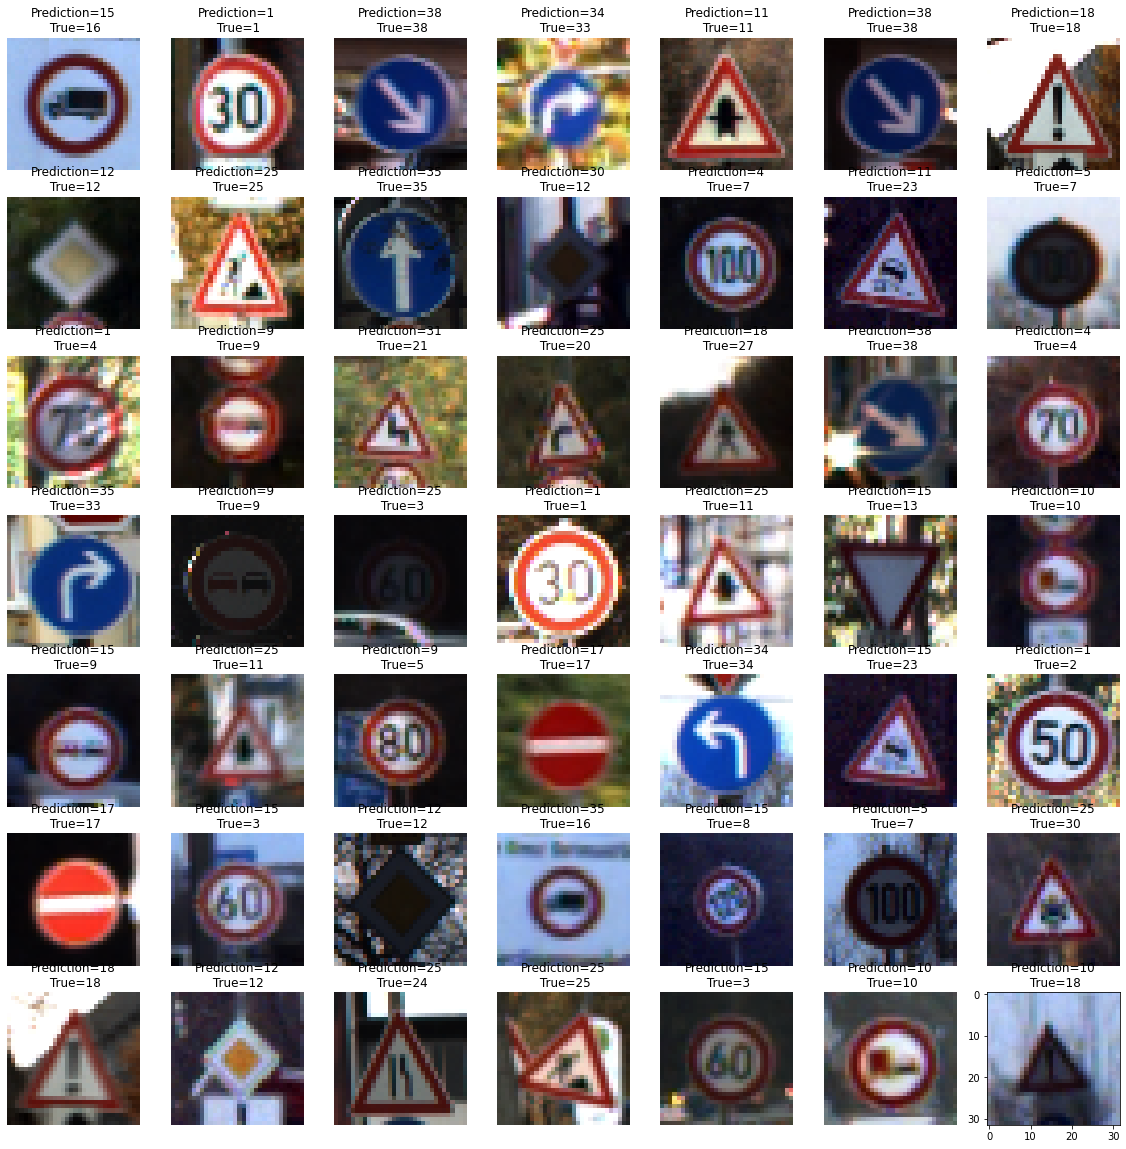

In [76]:
# Generar un cuadro de 7 X 7 con los primeros 49 rótulos del conjunto de prueba y 
#   para cada uno colocar de título la etiqueta verdadera y el código predicho por el 
#   modelo

fig = plt.figure(figsize= (20, 20))

for i in np.arange(0, 49):
  ax = fig.add_subplot(7, 7, i+1)
  ax.imshow(X_prueba[i])
  ax.set_title("Prediction={}\n True={}".format(clases_predichas[i], y_prueba[i]))
  

#  Ajustes del modelo

Como se puede ver, hay muchos lugares donde se puede cambiar la configuración del modelo.  A continuación se sugieren varias posibilidades que deben probar e indicar si se mejora la exactitud del modelo:

1. Incrementar el número de épocas para el entrenamiento a 500 ó 1,000
2. En las capas de convolución cambiar el tamaño del kernel a 10 X 10
3. Cambiar el método de submuestrear (pooling) a MaxPooling
4. Cambiar el numero de la segunda capa plenamente conectada de 84 a 100 unidades
5. Cambiar el número de la primera capa plenamente conectada de 120 a 300 unidades

La idea es ir haciendo los cambios uno por uno y ver cómo va cambiando la exactitud del modelo

1. Incrementar el número de épocas para el entrenamiento a 500 ó 1,000

In [28]:
model = Sequential([
    Rescaling(1, input_shape=(32, 32, 3)),
    Conv2D(filters=6, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=400, kernel_size=(5, 5), activation='relu'),
    Dropout(0.2), 
    Flatten(),
    Dense(units=120, activation='relu'),
    Dense(units=43, activation='softmax')
])

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

eps = 500

newAnc = model.fit(X_entreno, y_t1, batch_size=32, epochs=eps, validation_data=(X_validacion, y_t2))

Epoch 1/500
 194/1088 [====>.........................] - ETA: 15s - loss: 2.6517 - accuracy: 0.3014

KeyboardInterrupt: 

2. En las capas de convolución cambiar el tamaño del kernel a 10 X 10

In [ ]:
model = Sequential([
    Rescaling(1, input_shape=(32, 32, 3)),
    Conv2D(filters=6, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=400, kernel_size=(5, 5), activation='relu'),
    Dropout(0.2), 
    Flatten(),
    Dense(units=120, activation='relu'),
    Dense(units=43, activation='softmax')
])

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

eps = 15

newAnc = model.fit(X_entreno, y_t1, batch_size=32, epochs=eps, validation_data=(X_validacion, y_t2))

Epoch 1/15
1088/1088 [==============================] - 10s 9ms/step - loss: 1.0085 - accuracy: 0.7058 - val_loss: 0.4404 - val_accuracy: 0.8615
Epoch 2/15
1088/1088 [==============================] - 10s 9ms/step - loss: 0.2242 - accuracy: 0.9331 - val_loss: 0.2891 - val_accuracy: 0.9116
Epoch 3/15
1088/1088 [==============================] - 10s 9ms/step - loss: 0.1312 - accuracy: 0.9611 - val_loss: 0.2925 - val_accuracy: 0.9195
Epoch 4/15
1088/1088 [==============================] - 10s 9ms/step - loss: 0.0877 - accuracy: 0.9743 - val_loss: 0.2569 - val_accuracy: 0.9372
Epoch 5/15
1088/1088 [==============================] - 10s 9ms/step - loss: 0.0609 - accuracy: 0.9821 - val_loss: 0.2068 - val_accuracy: 0.9424
Epoch 6/15
1088/1088 [==============================] - 9s 9ms/step - loss: 0.0525 - accuracy: 0.9836 - val_loss: 0.2761 - val_accuracy: 0.9363
Epoch 7/15
1088/1088 [==============================] - 9s 9ms/step - loss: 0.0444 - accuracy: 0.9867 - val_loss: 0.2761 - val_accu

3. Cambiar el método de submuestrear (pooling) a MaxPooling

In [ ]:
from keras.layers import MaxPooling2D

model = Sequential([
    Rescaling(1, input_shape=(32, 32, 3)),
    Conv2D(filters=6, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=400, kernel_size=(5, 5), activation='relu'),
    Dropout(0.2), 
    Flatten(),
    Dense(units=120, activation='relu'),
    Dense(units=43, activation='softmax')
])

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

eps = 15

newAnc = model.fit(X_entreno, y_t1, batch_size=32, epochs=eps, validation_data=(X_validacion, y_t2))

Epoch 1/15
1088/1088 [==============================] - 10s 9ms/step - loss: 0.8546 - accuracy: 0.7569 - val_loss: 0.3975 - val_accuracy: 0.8757
Epoch 2/15
1088/1088 [==============================] - 11s 10ms/step - loss: 0.1593 - accuracy: 0.9531 - val_loss: 0.2967 - val_accuracy: 0.9302
Epoch 3/15
1088/1088 [==============================] - 9s 9ms/step - loss: 0.0902 - accuracy: 0.9733 - val_loss: 0.2878 - val_accuracy: 0.9190
Epoch 4/15
1088/1088 [==============================] - 10s 9ms/step - loss: 0.0684 - accuracy: 0.9786 - val_loss: 0.3168 - val_accuracy: 0.9215
Epoch 5/15
1088/1088 [==============================] - 10s 10ms/step - loss: 0.0527 - accuracy: 0.9843 - val_loss: 0.2770 - val_accuracy: 0.9379
Epoch 6/15
1088/1088 [==============================] - 11s 10ms/step - loss: 0.0454 - accuracy: 0.9861 - val_loss: 0.2417 - val_accuracy: 0.9410
Epoch 7/15
1088/1088 [==============================] - 11s 10ms/step - loss: 0.0367 - accuracy: 0.9883 - val_loss: 0.2749 - val

4. Cambiar el numero de la segunda capa plenamente conectada de 84 a 100 unidades

In [ ]:
model = Sequential([
    Rescaling(1, input_shape=(32, 32, 3)),
    Conv2D(filters=6, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=400, kernel_size=(5, 5), activation='relu'),
    Dropout(0.2), 
    Flatten(),
    Dense(units=120, activation='relu'),
    Dense(units=43, activation='softmax')
    # Dense(units=100, activation='softmax')
])

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

eps = 15

newAnc = model.fit(X_entreno, y_t1, batch_size=32, epochs=eps, validation_data=(X_validacion, y_t2))

Epoch 1/15
1088/1088 [==============================] - 9s 8ms/step - loss: 0.9106 - accuracy: 0.7416 - val_loss: 0.4366 - val_accuracy: 0.8574
Epoch 2/15
1088/1088 [==============================] - 10s 9ms/step - loss: 0.2235 - accuracy: 0.9353 - val_loss: 0.3564 - val_accuracy: 0.8834
Epoch 3/15
1088/1088 [==============================] - 9s 8ms/step - loss: 0.1272 - accuracy: 0.9631 - val_loss: 0.2949 - val_accuracy: 0.9116
Epoch 4/15
1088/1088 [==============================] - 9s 8ms/step - loss: 0.0878 - accuracy: 0.9738 - val_loss: 0.2926 - val_accuracy: 0.9231
Epoch 5/15
1088/1088 [==============================] - 9s 9ms/step - loss: 0.0664 - accuracy: 0.9802 - val_loss: 0.2583 - val_accuracy: 0.9263
Epoch 6/15
1088/1088 [==============================] - 10s 10ms/step - loss: 0.0530 - accuracy: 0.9832 - val_loss: 0.2657 - val_accuracy: 0.9304
Epoch 7/15
1088/1088 [==============================] - 11s 10ms/step - loss: 0.0428 - accuracy: 0.9863 - val_loss: 0.2306 - val_accu

5. Cambiar el número de la primera capa plenamente conectada de 120 a 300 unidades

In [ ]:
model = Sequential([
    Rescaling(1, input_shape=(32, 32, 3)),
    Conv2D(filters=6, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=400, kernel_size=(5, 5), activation='relu'),
    Dropout(0.2), 
    Flatten(),
    Dense(units=300, activation='relu'),
    Dense(units=43, activation='softmax')
])

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

eps = 15

newAnc = model.fit(X_entreno, y_t1, batch_size=32, epochs=eps, validation_data=(X_validacion, y_t2))

Epoch 1/15
1088/1088 [==============================] - 11s 9ms/step - loss: 0.9551 - accuracy: 0.7217 - val_loss: 0.4637 - val_accuracy: 0.8553
Epoch 2/15
1088/1088 [==============================] - 20s 18ms/step - loss: 0.2306 - accuracy: 0.9314 - val_loss: 0.3401 - val_accuracy: 0.9005
Epoch 3/15
1088/1088 [==============================] - 22s 20ms/step - loss: 0.1335 - accuracy: 0.9598 - val_loss: 0.2767 - val_accuracy: 0.9204
Epoch 4/15
1088/1088 [==============================] - 22s 20ms/step - loss: 0.0918 - accuracy: 0.9727 - val_loss: 0.2719 - val_accuracy: 0.9333
Epoch 5/15
1088/1088 [==============================] - 25s 23ms/step - loss: 0.0714 - accuracy: 0.9785 - val_loss: 0.2636 - val_accuracy: 0.9340
Epoch 6/15
1088/1088 [==============================] - 22s 20ms/step - loss: 0.0549 - accuracy: 0.9831 - val_loss: 0.3723 - val_accuracy: 0.9118
Epoch 7/15
1088/1088 [==============================] - 21s 19ms/step - loss: 0.0474 - accuracy: 0.9845 - val_loss: 0.3084 - 